In [1]:
import itertools
import numpy as np
import pandas as pd
import itertools
import numpy as np
from joblib import Parallel, delayed
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
import statsmodels.api as sm

In [2]:
# Convert CSV file to parquet
df = pd.read_csv("data/AverageDailyPolyclinicAttendancesforSelectedDiseases.csv")
df.to_parquet("data/AverageDailyPolyclinicAttendancesforSelectedDiseases.parquet", engine='pyarrow')

# 1. Explore and Understand Dataset

In [3]:
attendance_df = pd.read_parquet("data/AverageDailyPolyclinicAttendancesforSelectedDiseases.parquet")

attendance_df.head()

,epi_week,disease,no._of_cases
0,2012-W01,Acute Upper Respiratory Tract infections,2932
1,2012-W01,Acute Conjunctivitis,120
2,2012-W01,Acute Diarrhoea,491
3,2012-W01,Chickenpox,18
4,2012-W02,Acute Upper Respiratory Tract infections,3189


## 1.1 Visualize the Data

In [4]:
# Split the data up into the different diseases
acute_conjunctivitis_df = attendance_df[attendance_df["disease"] == "Acute Conjunctivitis"].reset_index(drop=True)
acute_diarrhoea_df = attendance_df[attendance_df["disease"] == "Acute Diarrhoea"].reset_index(drop=True)
acute_urti_df = attendance_df[attendance_df["disease"] == "Acute Upper Respiratory Tract infections"].reset_index(drop=True)

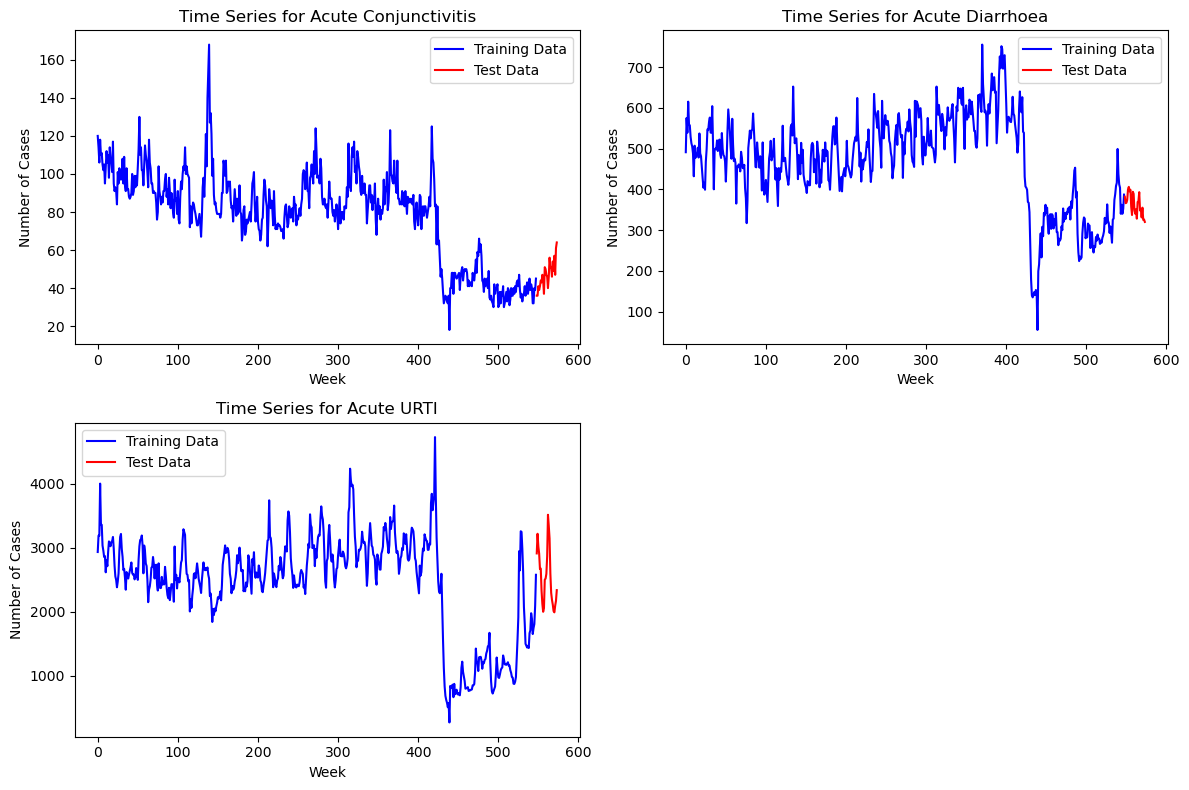

In [5]:
disease_data = {
    'Acute Conjunctivitis': acute_conjunctivitis_df,
    'Acute Diarrhoea': acute_diarrhoea_df,
    'Acute URTI': acute_urti_df
}

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (disease_name, data) in enumerate(disease_data.items()):
    # Split into train and tes set
    train_data = data[data['epi_week'] <= '2022-W26']
    test_data = data[data['epi_week'] > '2022-W26']
    
    axs[i].plot(train_data['no._of_cases'], label='Training Data', color='blue')
    axs[i].plot(test_data['no._of_cases'], label='Test Data', color='red')

    axs[i].set_title(f'Time Series for {disease_name}')
    axs[i].set_xlabel('Week')
    axs[i].set_ylabel('Number of Cases')
    axs[i].legend()

fig.delaxes(axs[3])
plt.tight_layout()
plt.show()

## 1.2 Train-Test Split

In [6]:
train_acute_conjunctivitis = acute_conjunctivitis_df[acute_conjunctivitis_df["epi_week"] <= "2022-W26"]
test_acute_conjunctivitis = acute_conjunctivitis_df[acute_conjunctivitis_df["epi_week"] > "2022-W26"]

train_acute_diarrhoea = acute_diarrhoea_df[acute_diarrhoea_df["epi_week"] <= "2022-W26"]
test_acute_diarrhoea = acute_diarrhoea_df[acute_diarrhoea_df["epi_week"] > "2022-W26"]

train_acute_urti = acute_urti_df[acute_urti_df["epi_week"] <= "2022-W26"]
test_acute_urti = acute_urti_df[acute_urti_df["epi_week"] > "2022-W26"]

# 2. Exploratory Data Analysis

## 2.1 Check for Stationarity

Using Adfuller, if p-value>0.05, it suggests that the series is not stationary. Hence, we will need to apply differencing.

In [7]:
adfuller_acute_conjunctivitis = adfuller(acute_conjunctivitis_df["no._of_cases"])  # Non-stationary
adfuller_acute_diarrhoea = adfuller(acute_diarrhoea_df["no._of_cases"])  # Non-stationary
adfuller_acute_urti = adfuller(acute_urti_df["no._of_cases"])  # Non-stationary

print(f"p-value of Adfuller for Acute Conjuntivitis: {adfuller_acute_conjunctivitis[1]}")
print(f"p-value of Adfuller for Acute Diarrhoea: {adfuller_acute_diarrhoea[1]}")
print(f"p-value of Adfuller for Acute URTI: {adfuller_acute_urti[1]}")

p-value of Adfuller for Acute Conjuntivitis: 0.15063704344956907
p-value of Adfuller for Acute Diarrhoea: 0.4457623387507087
p-value of Adfuller for Acute URTI: 0.06589875656694431


## 2.2 Check for Seasonality using ACF plot

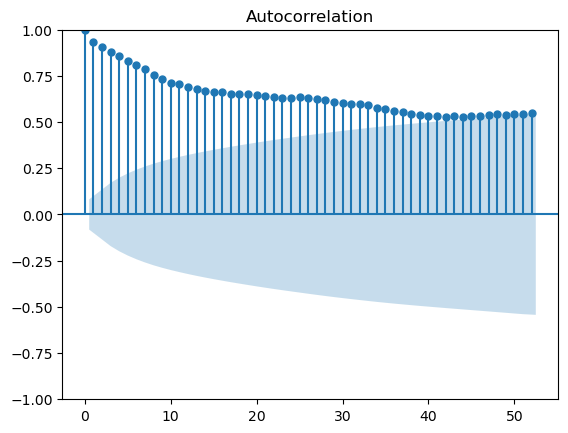

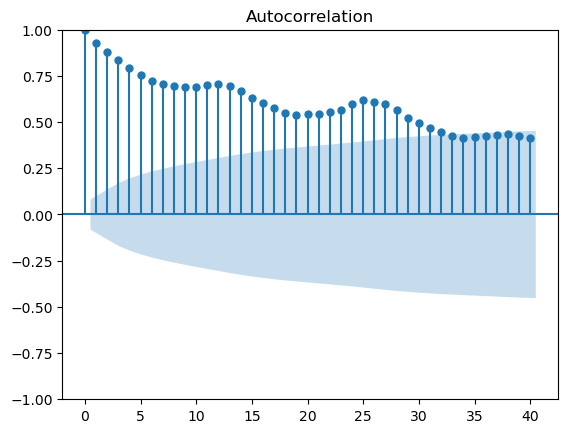

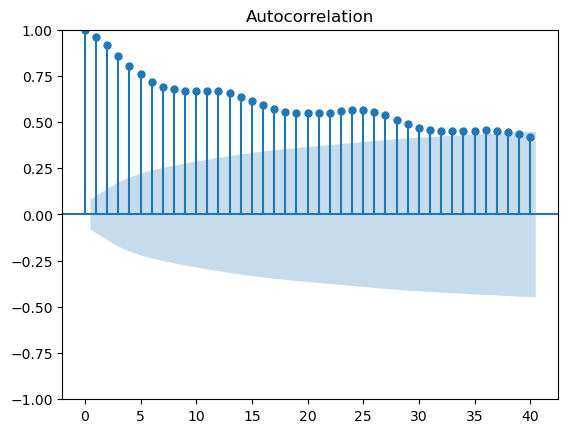

In [8]:
# period = 26 weeks (half a year)
acute_conjunctivitis_acf = plot_acf(acute_conjunctivitis_df["no._of_cases"], lags=52)
plt.show()

# period = 13 weeks (from one tip to another)
acute_diarrhoea_acf = plot_acf(acute_diarrhoea_df["no._of_cases"], lags=40)
plt.show()

# period = 13 weeks
acute_urti_acf = plot_acf(acute_urti_df["no._of_cases"], lags=40)
plt.show()

## 2. 3 Decompose the Time Series

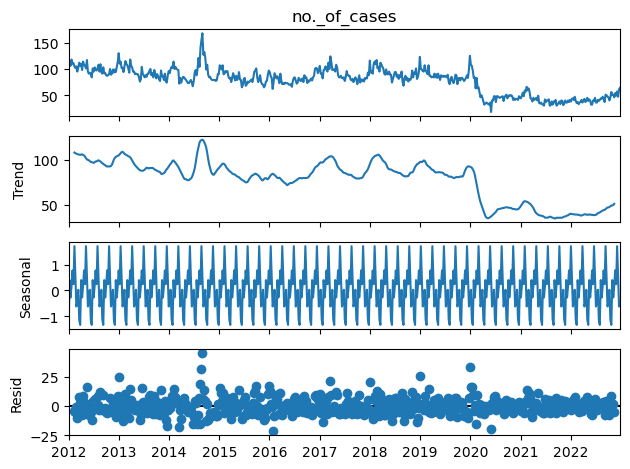

In [9]:
acute_conjunctivitis_decomposed_df = acute_conjunctivitis_df.copy()
acute_conjunctivitis_decomposed_df.index = pd.date_range(start='2012-01-01', periods=len(acute_conjunctivitis_df.index), freq='W')
series = acute_conjunctivitis_decomposed_df["no._of_cases"]
result = seasonal_decompose(series, model='additive', period=12)
result.plot()
pyplot.show()

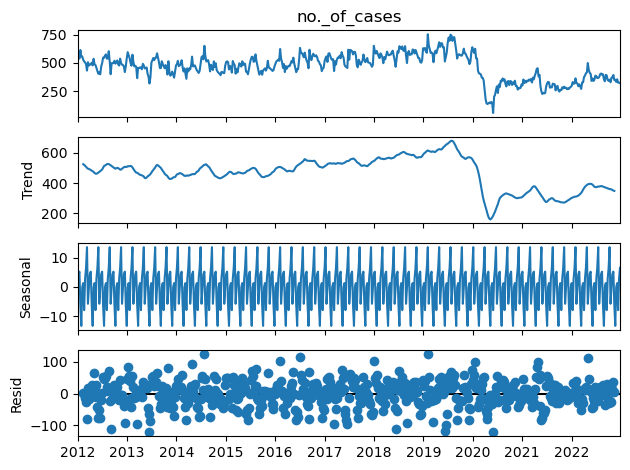

In [10]:
acute_diarrhoea_decomposed_df = acute_diarrhoea_df.copy()
acute_diarrhoea_decomposed_df.index = pd.date_range(start='2012-01-01', periods=len(acute_diarrhoea_df.index), freq='W')
series = acute_diarrhoea_decomposed_df["no._of_cases"]
result = seasonal_decompose(series, model='additive', period=12)
result.plot()
pyplot.show()

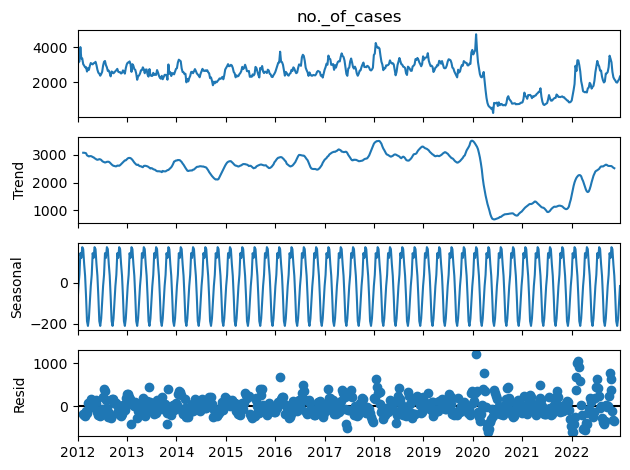

In [11]:
acute_urti_decomposed_df = acute_urti_df.copy()
acute_urti_decomposed_df.index = pd.date_range(start='2012-01-01', periods=len(acute_urti_df.index), freq='W')
series = acute_urti_decomposed_df["no._of_cases"]
result = seasonal_decompose(series, model='additive', period=13)
result.plot()
pyplot.show()

# 3. Model Selection and Training

* Regression Modelling
* Smoothing Methods
* ARIMA/SARIMA

In [12]:
all_losses = []

## 3.1 Classical Regression Modelling

Using the original dataset to model polynomial regression (degree 2 to degree 15).

In [13]:
X_train = np.array(train_acute_conjunctivitis.index).reshape(-1, 1)
y_train = train_acute_conjunctivitis["no._of_cases"]

X_test = np.array(test_acute_conjunctivitis.index).reshape(-1, 1)
y_test = test_acute_conjunctivitis["no._of_cases"]

best_degree = None
smallest_mse = np.inf
for degree in range(2, 30):
    # Create polynomial features
    pr = PolynomialFeatures(degree=degree)
    X_train_poly = pr.fit_transform(X_train)
    X_test_poly = pr.transform(X_test)

    # Fit the polynomial regression model
    lr = LinearRegression()
    lr.fit(X_train_poly, y_train)

    # Predictions
    y_pred_train = lr.predict(X_train_poly)
    y_pred_test = lr.predict(X_test_poly)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    if mse_test < smallest_mse:
        smallest_mse = mse_test
        best_degree = degree

all_losses.append({
    'Disease': 'Acute Conjuntivitis',
    'Model': f'Polynomial Regression \n(degree={best_degree})',
    'MSE Loss': smallest_mse
})
print("Best Degree:", best_degree)
print("Smallest MSE:", smallest_mse)

Best Degree: 16
Smallest MSE: 48.66061046321226


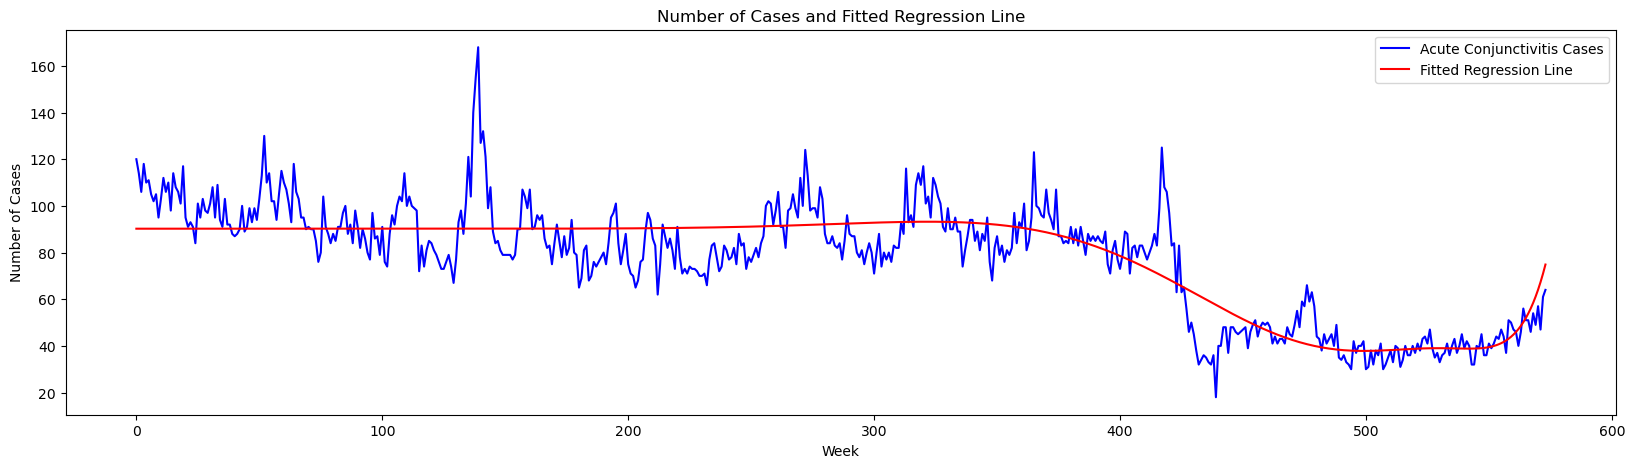

In [14]:
# Plot the best polynomial model (p=16)
pr = PolynomialFeatures(degree=16)
X_train_poly = pr.fit_transform(X_train)
X_test_poly = pr.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_poly, y_train)

y_pred_train = lr.predict(X_train_poly)
y_pred_test = lr.predict(X_test_poly)

plt.figure(figsize=(20, 5))
plt.plot(acute_conjunctivitis_df.index, acute_conjunctivitis_df["no._of_cases"], label='Acute Conjunctivitis Cases', color='blue')
plt.plot(X_train, y_pred_train, color='red')
plt.plot(X_test, y_pred_test, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Number of Cases and Fitted Regression Line')
plt.legend()
plt.show()

In [15]:
X_train = np.array(train_acute_diarrhoea.index).reshape(-1, 1)
y_train = train_acute_diarrhoea["no._of_cases"]

X_test = np.array(test_acute_diarrhoea.index).reshape(-1, 1)
y_test = test_acute_diarrhoea["no._of_cases"]

best_degree = None
smallest_mse = np.inf
for degree in range(2, 30):
    # Create polynomial features
    pr = PolynomialFeatures(degree=degree)
    X_train_poly = pr.fit_transform(X_train)
    X_test_poly = pr.transform(X_test)

    # Fit the polynomial regression model
    lr = LinearRegression()
    lr.fit(X_train_poly, y_train)

    # Predictions
    y_pred_train = lr.predict(X_train_poly)
    y_pred_test = lr.predict(X_test_poly)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    if mse_test < smallest_mse:
        smallest_mse = mse_test
        best_degree = degree
        
all_losses.append({
    'Disease': 'Acute Diarrhoea',
    'Model': f'Polynomial Regression \n(degree={best_degree})',
    'MSE Loss': smallest_mse
})
print("Best Degree:", best_degree)
print("Smallest MSE:", smallest_mse)

Best Degree: 9
Smallest MSE: 524.7181311506837


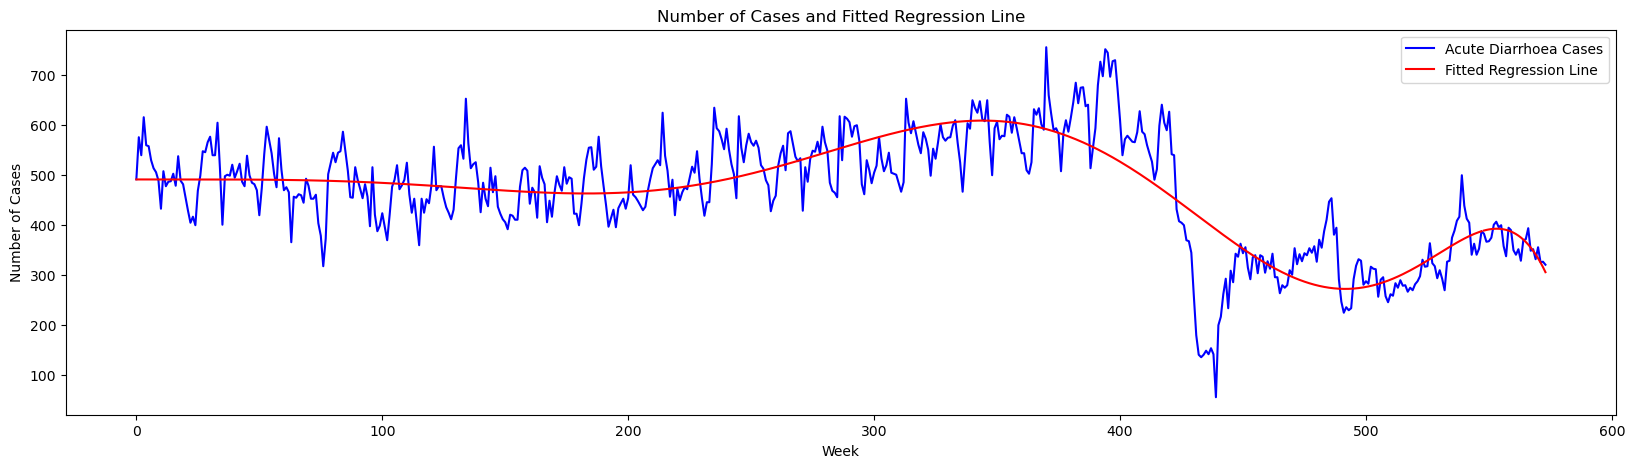

In [16]:
# Plot the best polynomial model (p=9)
pr = PolynomialFeatures(degree=9)
X_train_poly = pr.fit_transform(X_train)
X_test_poly = pr.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_poly, y_train)

y_pred_train = lr.predict(X_train_poly)
y_pred_test = lr.predict(X_test_poly)

plt.figure(figsize=(20, 5))
plt.plot(acute_diarrhoea_df.index, acute_diarrhoea_df["no._of_cases"], label='Acute Diarrhoea Cases', color='blue')
plt.plot(X_train, y_pred_train, color='red')
plt.plot(X_test, y_pred_test, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Number of Cases and Fitted Regression Line')
plt.legend()
plt.show()

In [17]:
X_train = np.array(train_acute_urti.index).reshape(-1, 1)
y_train = train_acute_urti["no._of_cases"]

X_test = np.array(test_acute_urti.index).reshape(-1, 1)
y_test = test_acute_urti["no._of_cases"]

best_degree = None
smallest_mse = np.inf
for degree in range(2, 30):
    # Create polynomial features
    pr = PolynomialFeatures(degree=degree)
    X_train_poly = pr.fit_transform(X_train)
    X_test_poly = pr.transform(X_test)

    # Fit the polynomial regression model
    lr = LinearRegression()
    lr.fit(X_train_poly, y_train)

    # Predictions
    y_pred_train = lr.predict(X_train_poly)
    y_pred_test = lr.predict(X_test_poly)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    if mse_test < smallest_mse:
        smallest_mse = mse_test
        best_degree = degree

all_losses.append({
    'Disease': 'Acute URTI',
    'Model': f'Polynomial Regression \n(degree={best_degree})',
    'MSE Loss': smallest_mse
})
print("Best Degree:", best_degree)
print("Smallest MSE:", smallest_mse)

Best Degree: 9
Smallest MSE: 219712.01334248003


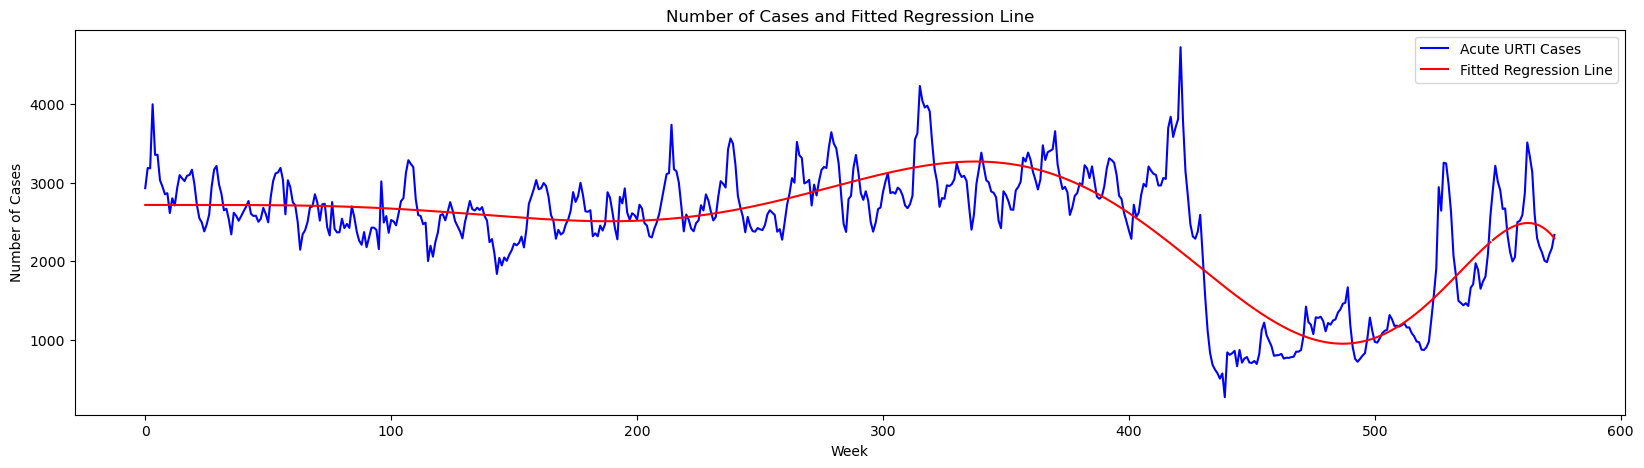

In [18]:
# Plot the best polynomial model (p=9)
pr = PolynomialFeatures(degree=9)
X_train_poly = pr.fit_transform(X_train)
X_test_poly = pr.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_poly, y_train)

y_pred_train = lr.predict(X_train_poly)
y_pred_test = lr.predict(X_test_poly)

plt.figure(figsize=(20, 5))
plt.plot(acute_urti_df.index, acute_urti_df["no._of_cases"], label='Acute URTI Cases', color='blue')
plt.plot(X_train, y_pred_train, color='red')
plt.plot(X_test, y_pred_test, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Number of Cases and Fitted Regression Line')
plt.legend()
plt.show()

In [19]:
# Using Holt's Winter Exponential Smoothing
hw_model = ExponentialSmoothing(
    train_acute_conjunctivitis["no._of_cases"], 
    trend='add',
    seasonal='add',
    seasonal_periods=26
)

smoothing_levels = [0.5, 0.6, 0.7, 0.8, 0.9]
smoothing_trends = [0.1, 0.2, 0.3, 0.4]
smoothing_seasonals = [0.1, 0.2, 0.3, 0.4, 0.5]

best_params = {}
smallest_mse = np.inf
for smoothing_level in smoothing_levels:
    for smoothing_trend in smoothing_trends:
        for smoothing_seasonal in smoothing_seasonals:
            
            hw_fit = hw_model.fit(
                        smoothing_level=smoothing_level,  # alpha (add more weight to recent observations)
                        smoothing_trend=smoothing_trend,  # beta
                        smoothing_seasonal=smoothing_seasonal
                    )
            
            # Forecast on test set
            forecast = hw_fit.forecast(steps=len(test_acute_conjunctivitis["no._of_cases"]))
    
            # Get the mse value
            mse = mean_squared_error(test_acute_conjunctivitis["no._of_cases"].values, forecast)
    
            if mse < smallest_mse:
                smallest_mse = mse
                best_params = {
                    'smoothing_level': smoothing_level,
                    'smoothing_trend': smoothing_trend,
                    'smoothing_seasonal': smoothing_seasonal
                }

all_losses.append({
    'Disease': 'Acute Conjuntivitis',
    'Model': f"Holt's Winter Smoothing Method, \nparams={best_params}",
    'MSE Loss': smallest_mse
})
print(best_params, smallest_mse)

{'smoothing_level': 0.5, 'smoothing_trend': 0.3, 'smoothing_seasonal': 0.5} 76.29896915936425


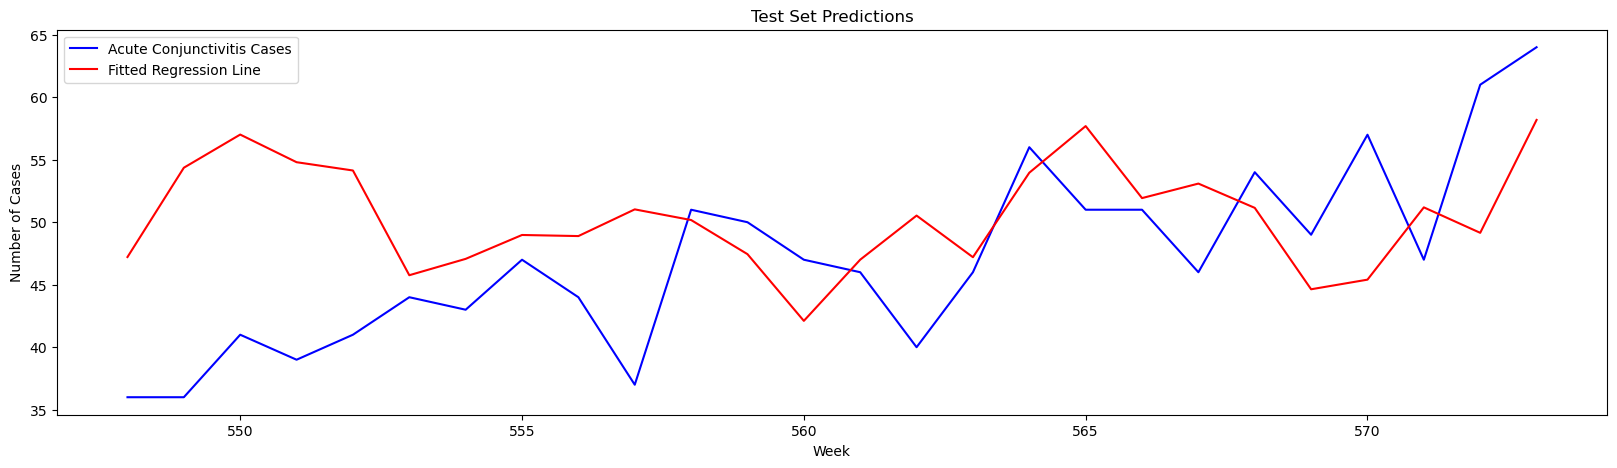

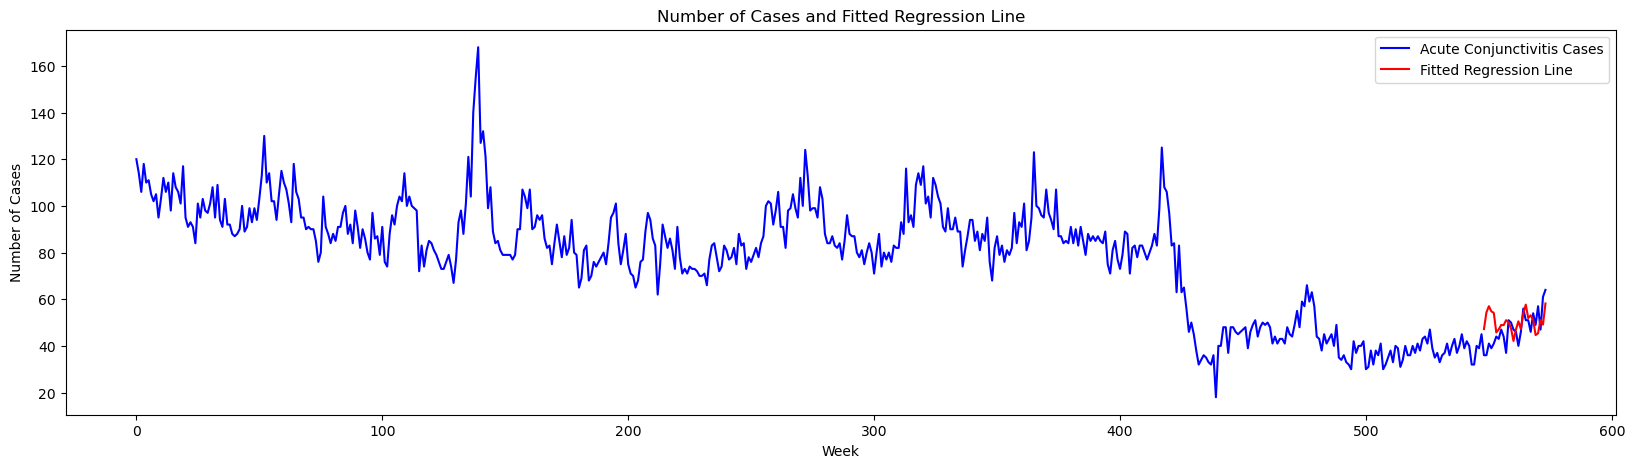

In [20]:
hw_model = ExponentialSmoothing(
    train_acute_conjunctivitis["no._of_cases"],
    trend='add',
    seasonal='add',
    seasonal_periods=26
)

hw_fit = hw_model.fit(
    smoothing_level=0.5,  # alpha (add more weight to recent observations)
    smoothing_trend=0.3,  # beta
    smoothing_seasonal=0.5
)

# Forecast on test set
forecast = hw_fit.forecast(steps=len(test_acute_conjunctivitis["no._of_cases"]))

plt.figure(figsize=(20, 5))
plt.plot(test_acute_conjunctivitis.index, test_acute_conjunctivitis["no._of_cases"], label='Acute Conjunctivitis Cases', color='blue')
plt.plot(test_acute_conjunctivitis.index, forecast, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Test Set Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(acute_conjunctivitis_df.index, acute_conjunctivitis_df["no._of_cases"], label='Acute Conjunctivitis Cases', color='blue')
plt.plot(test_acute_conjunctivitis.index, forecast, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Number of Cases and Fitted Regression Line')
plt.legend()
plt.show()

In [21]:
# Using Holt Winters Exponential Smoothing
hw_model = ExponentialSmoothing(
    train_acute_diarrhoea["no._of_cases"], 
    trend='add',
    seasonal='add',
    seasonal_periods=13
)

smoothing_levels = [0.5, 0.6, 0.7, 0.8, 0.9]
smoothing_trends = [0.1, 0.2, 0.3, 0.4]
smoothing_seasonals = [0.1, 0.2, 0.3, 0.4, 0.5]

best_params = {}
smallest_mse = np.inf
for smoothing_level in smoothing_levels:
    for smoothing_trend in smoothing_trends:
        for smoothing_seasonal in smoothing_seasonals:
            hw_fit = hw_model.fit(
                smoothing_level=smoothing_level,  # alpha (add more weight to recent observations)
                smoothing_trend=smoothing_trend,  # beta
                smoothing_seasonal=smoothing_seasonal
            )
    
            # Forecast on test set
            forecast = hw_fit.forecast(steps=len(test_acute_diarrhoea["no._of_cases"]))
    
            # Get the mse value
            mse = mean_squared_error(test_acute_diarrhoea["no._of_cases"].values, forecast)
    
            if mse < smallest_mse:
                smallest_mse = mse
                best_params = {
                    'smoothing_level': smoothing_level,
                    'smoothing_trend': smoothing_trend,
                    'smoothing_seasonal': smoothing_seasonal
                }

all_losses.append({
    'Disease': 'Acute Diarrhoea',
    'Model': f"Holt's Winter Smoothing Method, \nparams={best_params}",
    'MSE Loss': smallest_mse
})
print(best_params, smallest_mse)

{'smoothing_level': 0.5, 'smoothing_trend': 0.4, 'smoothing_seasonal': 0.3} 737.9251660300021


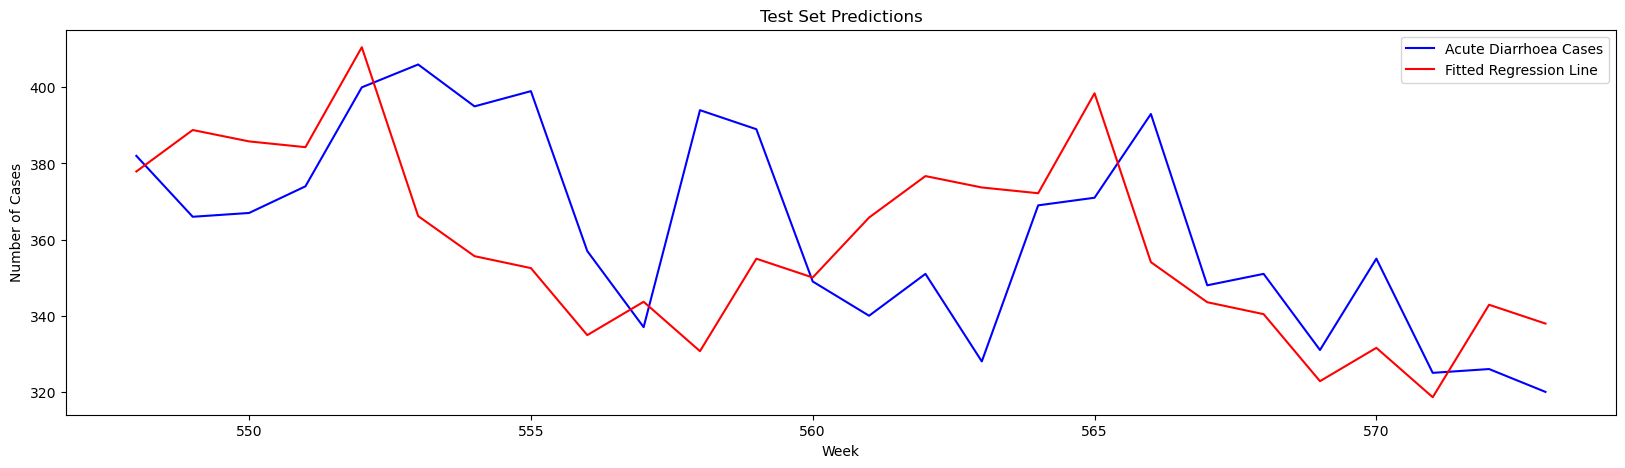

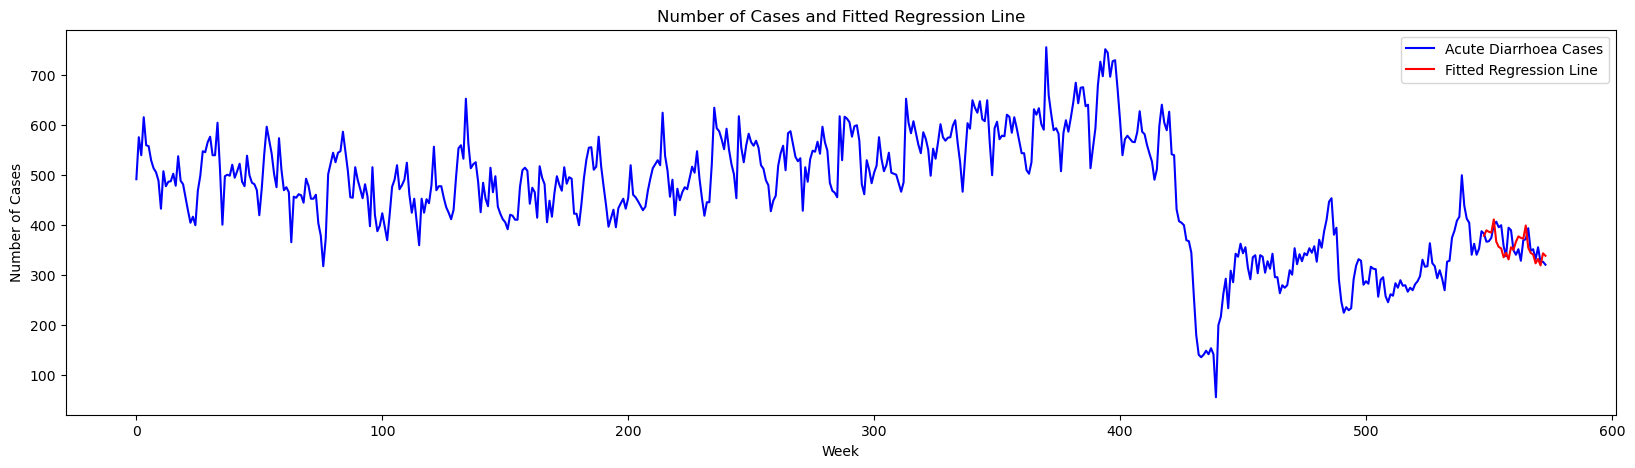

In [22]:
# Plot the forecast
hw_model = ExponentialSmoothing(
    train_acute_diarrhoea["no._of_cases"],
    trend='add',
    seasonal='add',
    seasonal_periods=13
)

hw_fit = hw_model.fit(
    smoothing_level=0.5,
    smoothing_trend=0.4,
    smoothing_seasonal=0.3
)

# Forecast on test set
forecast = hw_fit.forecast(steps=len(test_acute_diarrhoea["no._of_cases"]))

plt.figure(figsize=(20, 5))
plt.plot(test_acute_diarrhoea.index, test_acute_diarrhoea["no._of_cases"], label='Acute Diarrhoea Cases', color='blue')
plt.plot(test_acute_diarrhoea.index, forecast, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Test Set Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(acute_diarrhoea_df.index, acute_diarrhoea_df["no._of_cases"], label='Acute Diarrhoea Cases', color='blue')
# plt.plot(test_acute_diarrhoea.index, test_acute_diarrhoea["no._of_cases"], color='blue')
plt.plot(test_acute_diarrhoea.index, forecast, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Number of Cases and Fitted Regression Line')
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


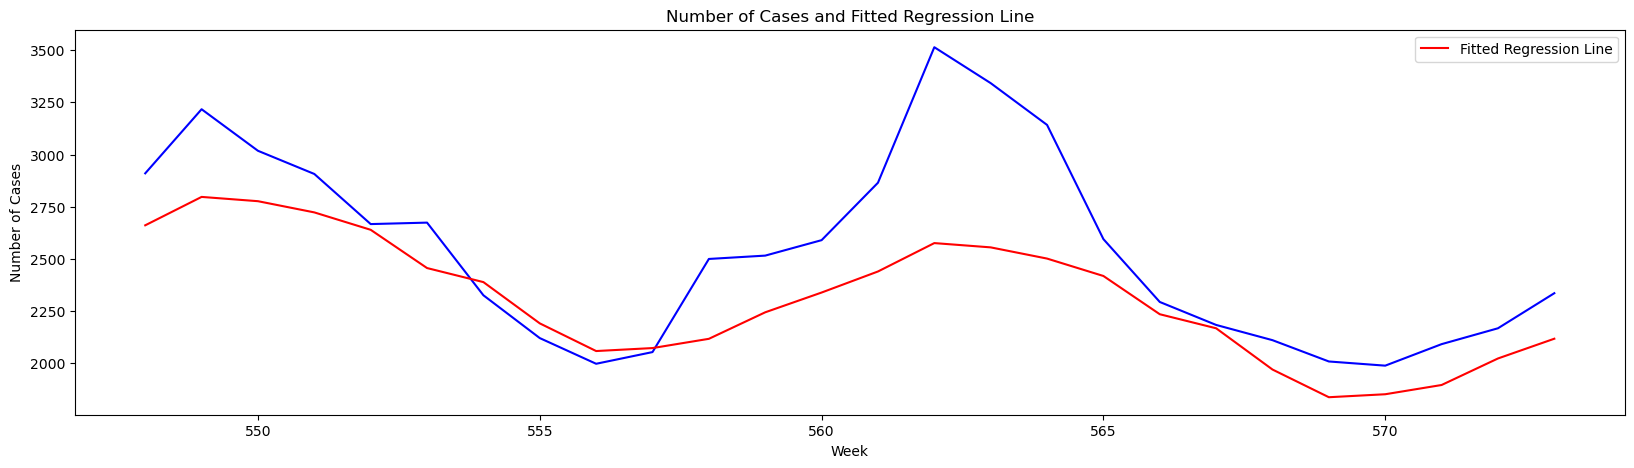

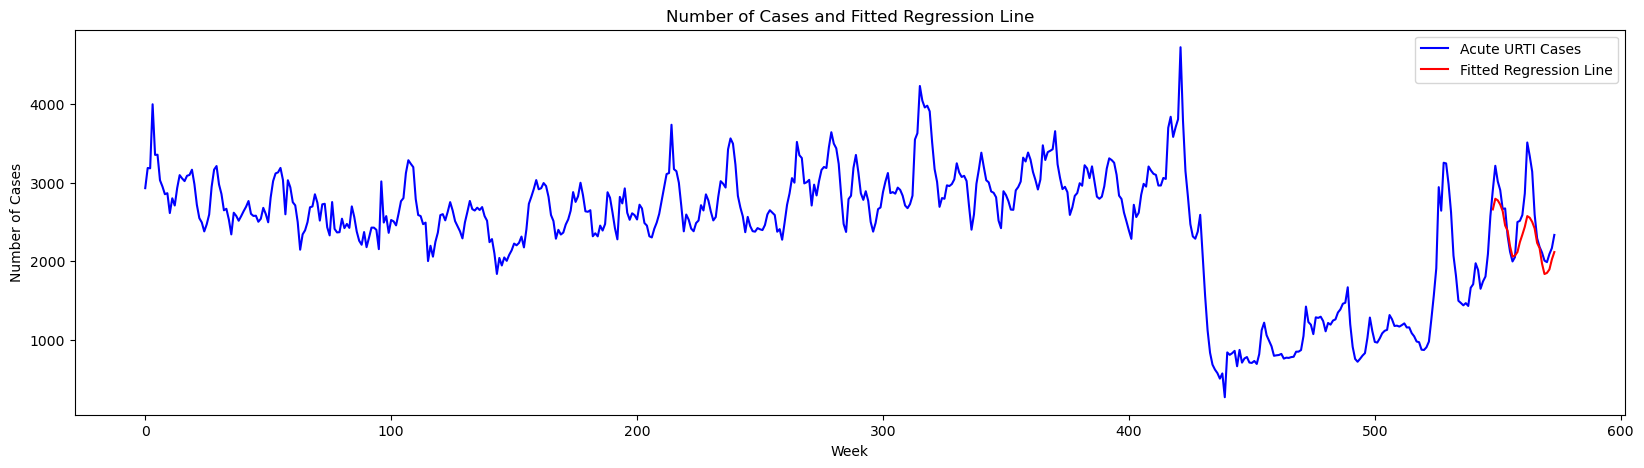

In [23]:
hw_model = ExponentialSmoothing(
    train_acute_urti["no._of_cases"], 
    trend='add',
    seasonal='add',
    seasonal_periods=13
)

hw_fit = hw_model.fit()

# Forecast on test set
forecast = hw_fit.forecast(steps=len(test_acute_urti["no._of_cases"]))

mse = mean_squared_error(test_acute_urti["no._of_cases"].values, forecast)

all_losses.append({
    'Disease': 'Acute URTI',
    'Model': f"Holt's Winter Smoothing Method",
    'MSE Loss': mse
})

plt.figure(figsize=(20, 5))
plt.plot(test_acute_urti.index, test_acute_urti["no._of_cases"], color='blue')
plt.plot(test_acute_urti.index, forecast, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Number of Cases and Fitted Regression Line')
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(acute_urti_df.index, acute_urti_df["no._of_cases"], label='Acute URTI Cases', color='blue')
plt.plot(test_acute_urti.index, forecast, label='Fitted Regression Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Number of Cases and Fitted Regression Line')
plt.legend()
plt.show()

## 3.2 Smoothing Methods

I will be using Exponential Smoothing method for Acute Conjunctivitis and Holt-Winters Exponential Smoothing for other two disease to give more weight to recent observations and take into account trends and seasonality in the data.

## 3.3 ARIMA/SARIMA Model

From the above Adfuller statistics, all diseases time series data are non-stationary. I will apply first-differencing (d=1) to Acute Conjunctivitis since it does not have an obvious seasonal trend and seasonal differencing where p=13 for Acute Diarrhoea and Acute URTI.

### 3.3.1 Transform Data

Since all three time series are non-stationary, apply differencing.

p-value of Adfuller for Acute Conjuntivitis: 7.763887730451543e-07


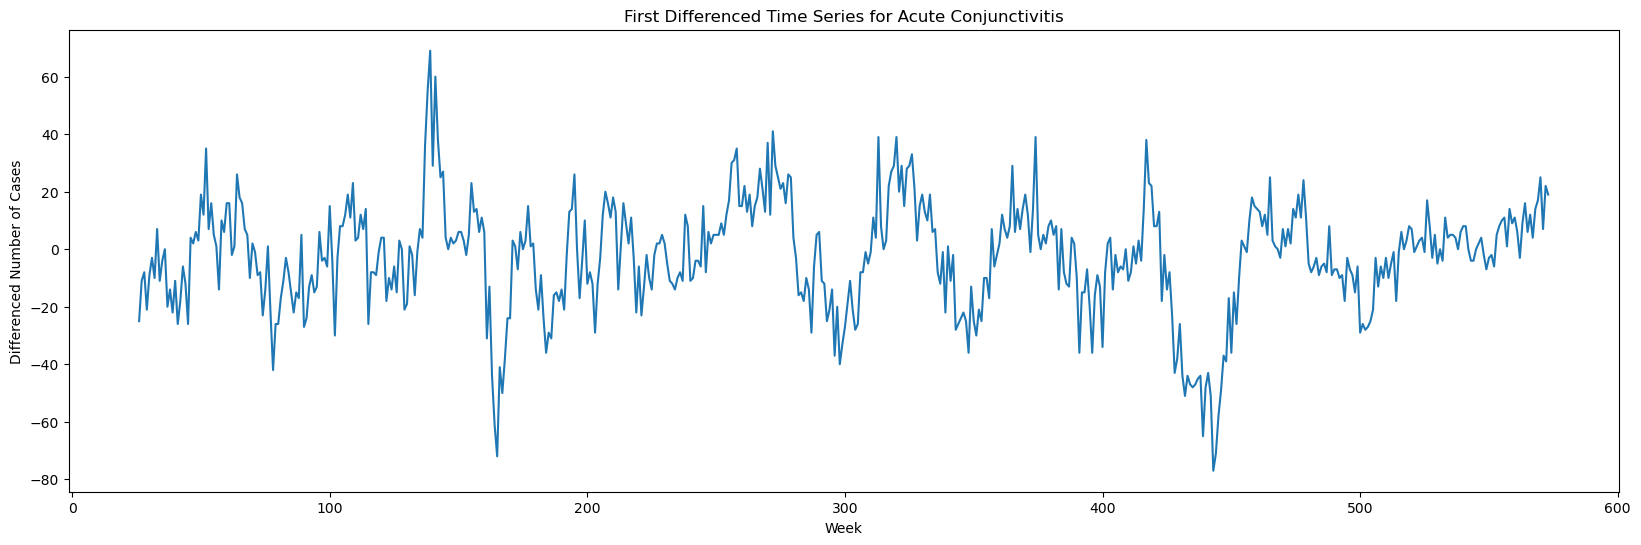

p-value of Adfuller for Acute Diarrhoea: 0.004334491251027746


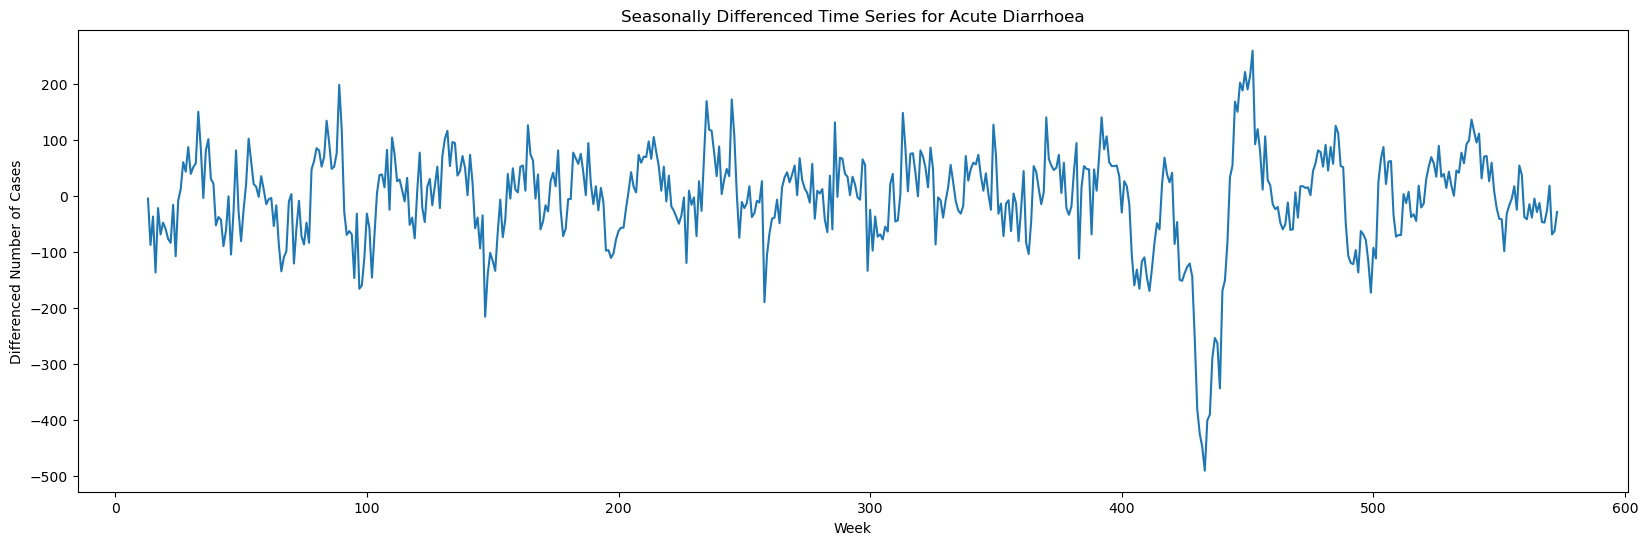

p-value of Adfuller for Acute URTI: 3.6446831111545503e-06


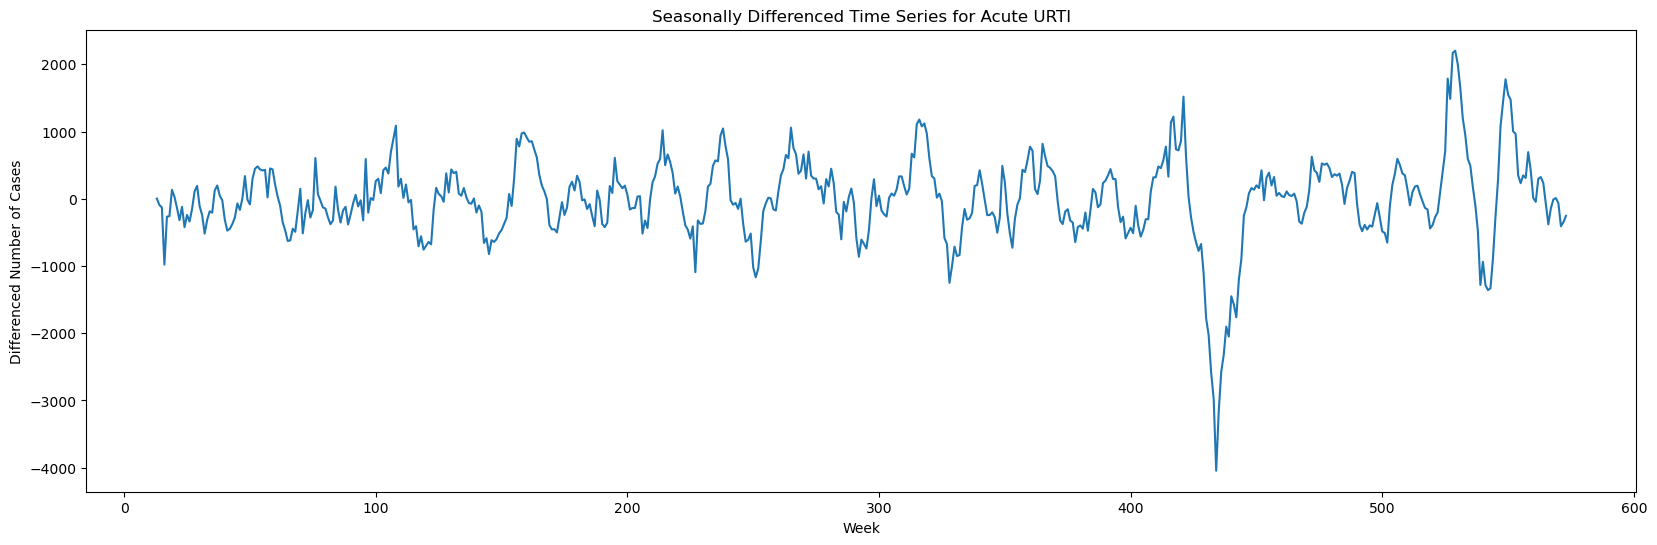

In [24]:
# Apply seasonal differencing
acute_conjunctivitis_diff = acute_conjunctivitis_df["no._of_cases"].diff(26) 
acute_diarrhoea_diff = acute_diarrhoea_df["no._of_cases"].diff(13)
acute_urti_diff = acute_urti_df["no._of_cases"].diff(13)

# Drop NA due to differencing
acute_conjunctivitis_diff = acute_conjunctivitis_diff.dropna()
acute_diarrhoea_diff = acute_diarrhoea_diff.dropna()
acute_urti_diff = acute_urti_diff.dropna()

print(f"p-value of Adfuller for Acute Conjuntivitis: {adfuller(acute_conjunctivitis_diff)[1]}")
plt.figure(figsize=(20, 6))
plt.plot(acute_conjunctivitis_diff, label='Acute Conjunctivitis Differenced')
plt.xlabel('Week')
plt.ylabel('Differenced Number of Cases')
plt.title('First Differenced Time Series for Acute Conjunctivitis')
plt.show()

print(f"p-value of Adfuller for Acute Diarrhoea: {adfuller(acute_diarrhoea_diff)[1]}")
plt.figure(figsize=(20, 6))
plt.plot(acute_diarrhoea_diff, label='Acute Diarrhoea Differenced')
plt.xlabel('Week')
plt.ylabel('Differenced Number of Cases')
plt.title('Seasonally Differenced Time Series for Acute Diarrhoea')
plt.show()

print(f"p-value of Adfuller for Acute URTI: {adfuller(acute_urti_diff)[1]}")
plt.figure(figsize=(20, 6))
plt.plot(acute_urti_diff, label='Acute URTI Differenced')
plt.xlabel('Week')
plt.ylabel('Differenced Number of Cases')
plt.title('Seasonally Differenced Time Series for Acute URTI')
plt.show()

In [25]:
# Get the differenced data
ac_diff_df = pd.DataFrame({
    'epi_week': acute_conjunctivitis_df["epi_week"][26:],  # Do not include the first 26 weeks
    'differenced_cases': acute_conjunctivitis_diff.values
})

ad_diff_df = pd.DataFrame({
    'epi_week': acute_diarrhoea_df["epi_week"][13:],  # Do not include the first 13 weeks
    'differenced_cases': acute_diarrhoea_diff.values
})

aurti_diff_df = pd.DataFrame({
    'epi_week': acute_urti_df["epi_week"][13:],  # Do not include the first 13 weeks
    'differenced_cases': acute_urti_diff.values
})

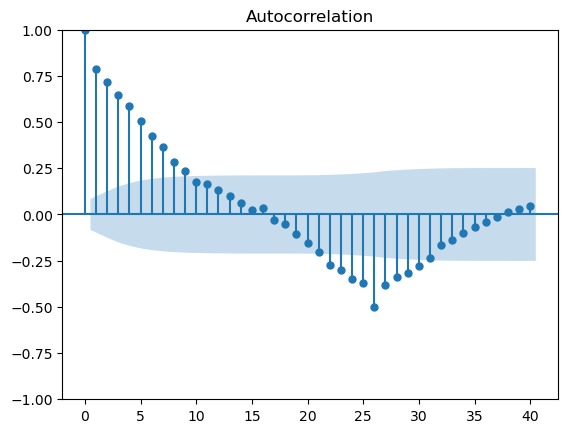

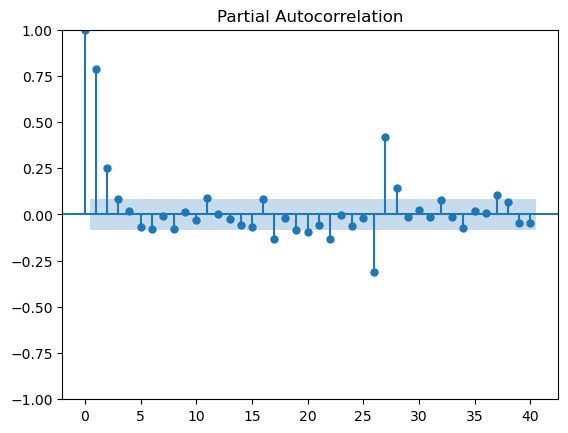

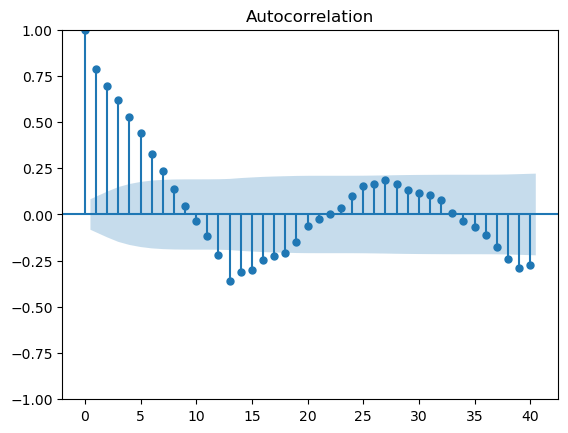

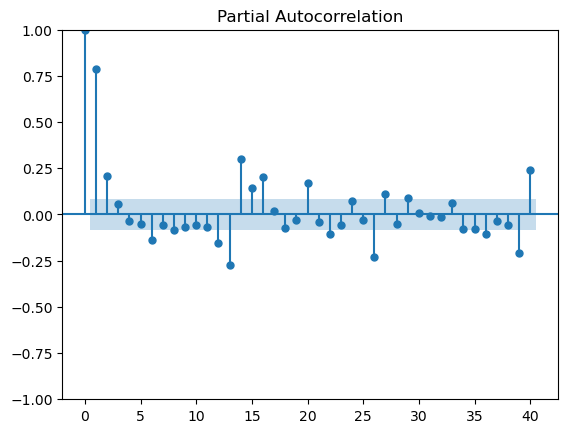

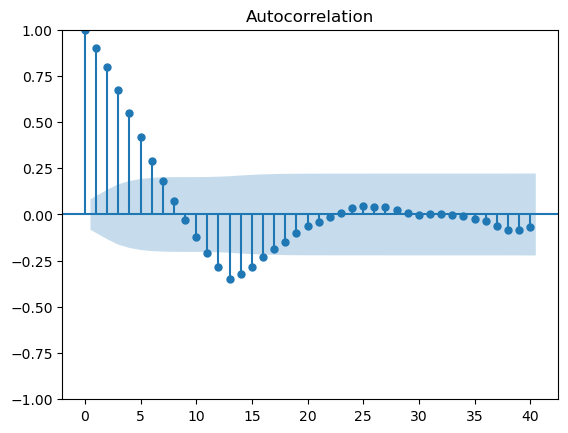

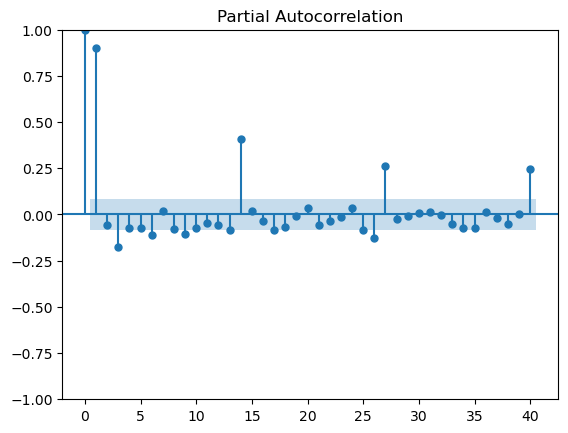

In [26]:
# After differencing, check the ACF and PACF plot again
acute_conjunctivitis_acf = plot_acf(ac_diff_df["differenced_cases"], lags=40)
acute_conjunctivitis_pacf = plot_pacf(ac_diff_df["differenced_cases"], lags=40)
plt.show()

acute_diarrhoea_acf = plot_acf(ad_diff_df["differenced_cases"], lags=40)
acute_diarrhoea_pacf = plot_pacf(ad_diff_df["differenced_cases"], lags=40)
plt.show()

acute_urti_acf = plot_acf(aurti_diff_df["differenced_cases"], lags=40)
acute_urti_pacf = plot_pacf(aurti_diff_df["differenced_cases"], lags=40)
plt.show()

In [27]:
# SARIMA for Acute Conjunctivitis
# Find the best p, d, q combination which gives the lowest AIC
p = d = q = range(0, 3)
seasonal_period = 13
seasonal_PDQ = [(1, 1, 1, seasonal_period)]

def evaluate_model(param, seasonal_param):
    try:
        model = SARIMAX(train_acute_conjunctivitis["no._of_cases"].values,
                        order=param,
                        seasonal_order=seasonal_param,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        return model_fit.aic, param
    except Exception as e:
        print(f"ARIMA{param}x{seasonal_param}: Exception {e}")
        return np.inf, param

results = Parallel(n_jobs=-1)(delayed(evaluate_model)(param, seasonal_param) 
                               for param in itertools.product(p, d, q)
                               for seasonal_param in seasonal_PDQ)

best_aic, best_params = min(results, key=lambda x: x[0])

print(f"Best AIC result: {best_aic}")
print(f"Best SARIMA params: {best_params}")

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best AIC result: 3700.152327272126
Best SARIMA params: (1, 1, 2)


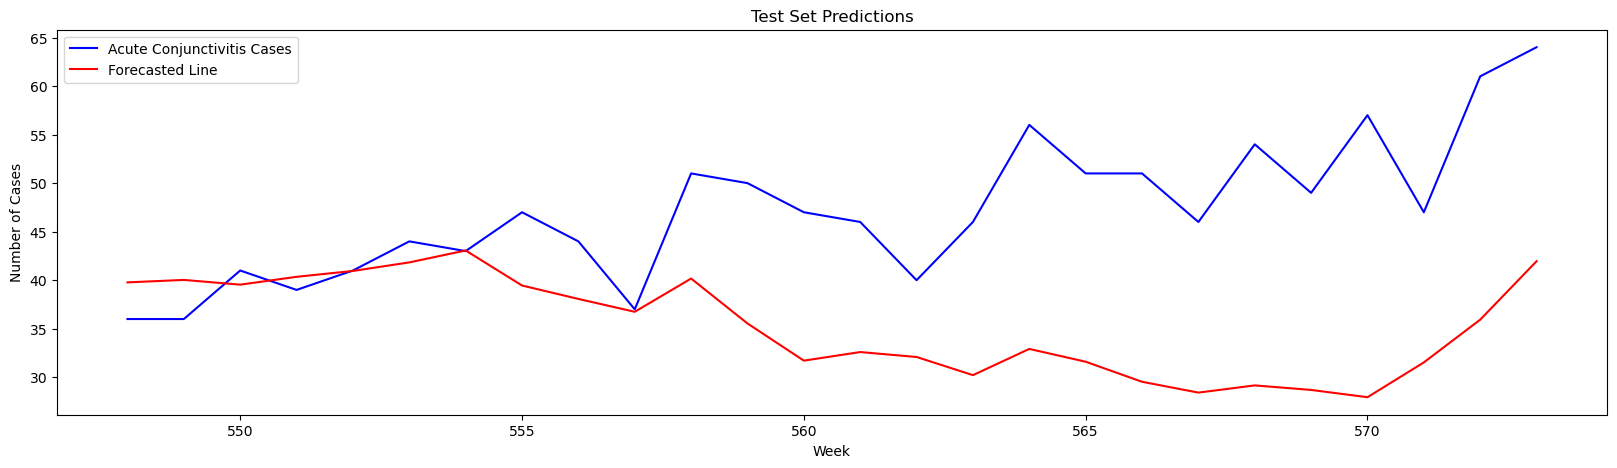

In [28]:
model = SARIMAX(train_acute_conjunctivitis["no._of_cases"].values,
                order=(1, 1, 2),
                seasonal_order=(1, 1, 1, 26),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=len(test_acute_conjunctivitis["no._of_cases"]))

all_losses.append({
    'Disease': 'Acute Conjunctivitis',
    'Model': f"SARIMAX, order=(1, 1, 2)",
    'MSE Loss': mean_squared_error(test_acute_conjunctivitis["no._of_cases"], forecast)
})

plt.figure(figsize=(20, 5))
plt.plot(test_acute_conjunctivitis.index, test_acute_conjunctivitis["no._of_cases"], label='Acute Conjunctivitis Cases', color='blue')
plt.plot(test_acute_conjunctivitis.index, forecast, label='Forecasted Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Test Set Predictions')
plt.legend()
plt.show()

In [29]:
# SARIMA for Acute Diarrhoea
p = d = q = range(0, 3)
seasinal_period = 13
seasonal_PDQ = [(1, 1, 1, seasonal_period)]

def evaluate_model(param, seasonal_param):
    try:
        model = SARIMAX(train_acute_diarrhoea["no._of_cases"].values,
                        order=param,
                        seasonal_order=seasonal_param,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        return model_fit.aic, param
    except Exception as e:
        print(f"ARIMA{param}x{seasonal_param}: Exception {e}")
        return np.inf, param

results = Parallel(n_jobs=-1)(delayed(evaluate_model)(param, seasonal_param) 
                               for param in itertools.product(p, d, q)
                               for seasonal_param in seasonal_PDQ)

best_aic, best_params = min(results, key=lambda x: x[0])

print(f"Best AIC result: {best_aic}")
print(f"Best SARIMA params: {best_params}")

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best AIC result: 5305.3643694199745
Best SARIMA params: (1, 1, 2)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


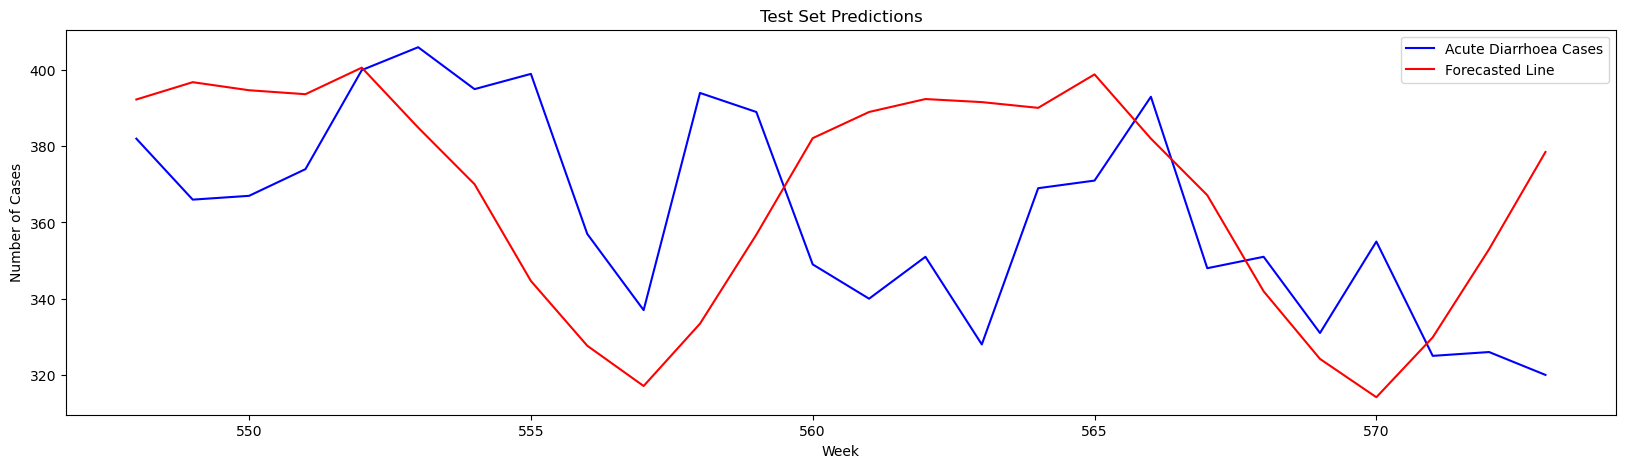

In [30]:
model = SARIMAX(train_acute_diarrhoea["no._of_cases"].values,
                order=(1, 1, 2),
                seasonal_order=(1, 1, 1, 13),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=len(test_acute_diarrhoea["no._of_cases"]))

all_losses.append({
    'Disease': 'Acute Diarrhoea',
    'Model': f"SARIMAX, order=(1, 1, 2)",
    'MSE Loss': mean_squared_error(test_acute_diarrhoea["no._of_cases"], forecast)
})

plt.figure(figsize=(20, 5))
plt.plot(test_acute_diarrhoea.index, test_acute_diarrhoea["no._of_cases"], label='Acute Diarrhoea Cases', color='blue')
plt.plot(test_acute_diarrhoea.index, forecast, label='Forecasted Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Test Set Predictions')
plt.legend()
plt.show()

In [31]:
# SARIMA for Acute URTI
p = d = q = range(0, 3)
seasinal_period = 13
seasonal_PDQ = [(1, 1, 1, seasonal_period)]

def evaluate_model(param, seasonal_param):
    try:
        model = SARIMAX(train_acute_urti["no._of_cases"].values,
                        order=param,
                        seasonal_order=seasonal_param,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        return model_fit.aic, param
    except Exception as e:
        print(f"ARIMA{param}x(1, 1, 1, 13): Exception {e}")
        return np.inf, param

results = Parallel(n_jobs=-1)(delayed(evaluate_model)(param, seasonal_param) 
                               for param in itertools.product(p, d, q)
                               for seasonal_param in seasonal_PDQ)

best_aic, best_params = min(results, key=lambda x: x[0])

print(f"Best AIC result: {best_aic}")
print(f"Best SARIMA params: {best_params}")

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best AIC result: 7000.783882015244
Best SARIMA params: (1, 2, 2)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


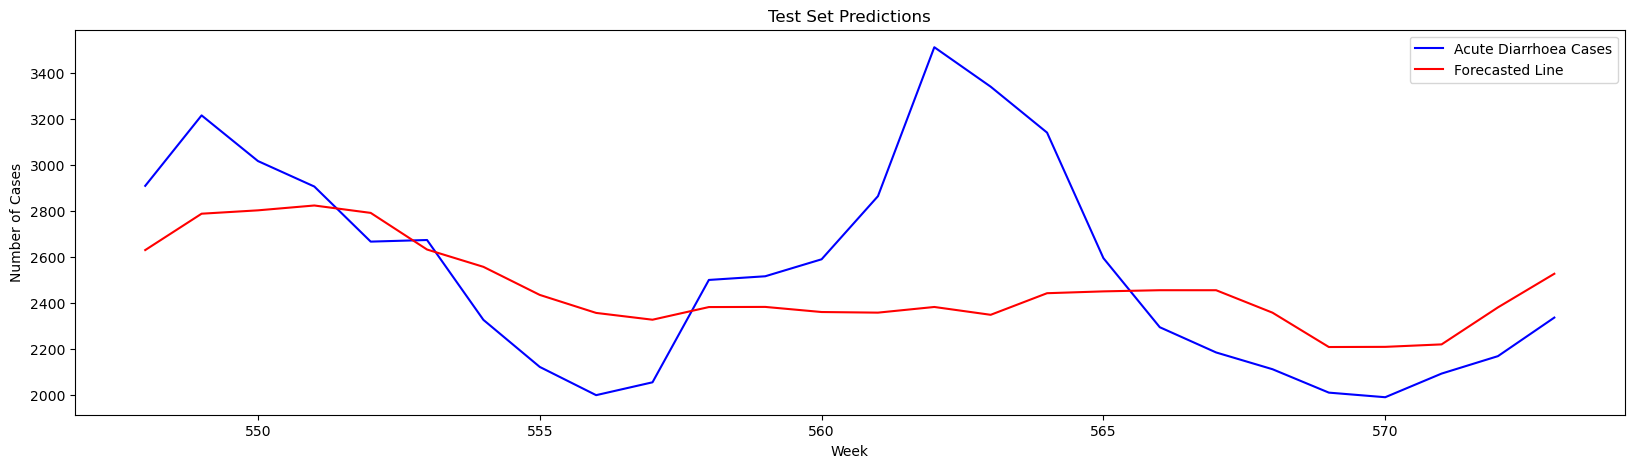

In [32]:
model = SARIMAX(train_acute_urti["no._of_cases"].values,
                order=(1, 2, 2),
                seasonal_order=(1, 1, 1, 26),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=len(test_acute_urti["no._of_cases"]))

all_losses.append({
    'Disease': 'Acute URTI',
    'Model': f"SARIMAX, order=(1, 2, 2)",
    'MSE Loss': mean_squared_error(test_acute_urti["no._of_cases"], forecast)
})

plt.figure(figsize=(20, 5))
plt.plot(test_acute_urti.index, test_acute_urti["no._of_cases"], label='Acute Diarrhoea Cases', color='blue')
plt.plot(test_acute_urti.index, forecast, label='Forecasted Line', color='red')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.title('Test Set Predictions')
plt.legend()
plt.show()

# Evaluation

After comparing the three different models - Classical Linear Regression, Smoothing Methods and SARIMA, the best performing model will be using Holt-Winter's Exponential Smoothing Method.

In [33]:
all_losses_df = pd.DataFrame(all_losses)
table = tabulate(all_losses_df, headers='keys', tablefmt='grid')

print(table)

+----+----------------------+------------------------------------------------------------------------------------+-------------+
|    | Disease              | Model                                                                              |    MSE Loss |
+====+======================+====================================================================================+=============+
|  0 | Acute Conjuntivitis  | Polynomial Regression                                                              |     48.6606 |
|    |                      | (degree=16)                                                                        |             |
+----+----------------------+------------------------------------------------------------------------------------+-------------+
|  1 | Acute Diarrhoea      | Polynomial Regression                                                              |    524.718  |
|    |                      | (degree=9)                                                         